In [2]:
import os

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import re



In [111]:
# Complex normal distribution
def cnormal(mean,std,size=1):
    return np.random.normal(np.real(mean), std, size)+1j*np.random.normal(np.imag(mean), std, size)

# Sampling from a discretely specified pdf using inverse transform sampling 
def sample_uniform_discrete(p):
    cdf_p = np.append(0,np.cumsum(p))
    v = np.random.random()
    idx = np.searchsorted(cdf_p,v,side='left')
    if cdf_p[idx]==cdf_p[idx-1]:
        return (idx-1)/(len(cdf_p)-1)
    return (idx+(v-cdf_p[idx-1])/(cdf_p[idx]-cdf_p[idx-1])-1)/(len(cdf_p)-1)

def gibbs_sampler_interference(x,K=20,alpha_dirichlet=np.ones(20),sigma_beta=1,phi_discretization=30,iterations=2): #Take the input data and number of components, and K-Dirichlet hyperparameter
    
    d = np.shape(x)[1]
    n = np.shape(x)[0]
    print('# Data points: ', n)
    print('# Data dimension: ', d)
    print('# Clusters: ', K)
    
    #Initialize Latent Variables (theta,beta,z)
    theta = np.ones(K)*1/K
    beta = cnormal(0,sigma_beta,(K,d))
    z = np.random.choice(K,(n,))
    phi = np.random.random((n,1))
    log_likelihoods = np.zeros(iterations)
    
    for iteration in range(iterations):
        
        log_likelihood = 0
        
        #Sample theta given z
        theta = np.random.dirichlet(alpha_dirichlet+np.sum(z,axis=0))
        log_likelihood += np.log(sp.stats.dirichlet.pdf(theta,alpha_dirichlet))
#         print('Sampled Theta',log_likelihood)
        
        #Sample beta given z and x and phi
        for k in range(K):
            n_k = np.sum(z==k)
            beta[k,:] = (np.sum(x[z==k,:]*np.exp(-2j*np.pi*phi[z==k,:]),axis=0))/(n_k+1/sigma_beta**2)
            log_likelihood += np.sum(np.log(sp.stats.norm.pdf(np.real(beta[k]),0,sigma_beta)))+\
            np.sum(np.log(sp.stats.norm.pdf(np.imag(beta[k]),0,sigma_beta)))
#         print('Sampled beta',log_likelihood)
        
        #Sample phi given beta and z and x
        for i in range(n):
#             p = np.zeros(phi_discretization) #Probability for each of the phi_discretization values
            p_log = np.zeros(phi_discretization)
            for j in range(phi_discretization):
                phi_j = (j+1)/phi_discretization
                p_log[j] = (-np.linalg.norm(beta[z[i],:]*np.exp(2j*np.pi*phi_j)-x[i,:])**2)
            p_log-=np.max(p_log)
            p = np.exp(p_log)
            p = p/np.sum(p)
            phi[i] = sample_uniform_discrete(p)
        #Ignoring p(phi) for log-likelihood as it is a unifrom marginal distribution
#         print('Sampled phi',log_likelihood)
            
        #Sample z_i given beta and x_i and phi
        for i in range(n):
#             p = np.zeros(K) #Probability for each of the K clusters
            p_log = np.zeros(K) #Probability for each of the K clusters
            for k in range(K):
#                 p[k] = theta[k]*np.exp(-np.linalg.norm(beta[k,:]*np.exp(2j*np.pi*phi[i])-x[i,:])**2)
                p_log[k] = (-np.linalg.norm(beta[k,:]*np.exp(2j*np.pi*phi[i])-x[i,:])**2)
            p_log-=np.max(p_log)
            p = theta*np.exp(p_log)
            p = p/np.sum(p)
            z[i] = np.random.choice(K,p=p)
            #p(z_i|\theta)
            log_likelihood += np.log(p[z[i]])
            #p(x_i|z_i,\beta)
            log_likelihood += np.sum(np.log(sp.stats.norm.pdf(np.real(x[i]), np.real(beta[z[i]]*np.exp(2j*np.pi*phi[i])), 1)))+\
            np.sum(np.log(sp.stats.norm.pdf(np.imag(x[i]), np.imag(beta[z[i]]*np.exp(2j*np.pi*phi[i])), 1)))
#         print('Sampled z_i',log_likelihood)
        if not (iteration+1)%max(iterations//10,1):
            print('# Iteration', iteration,'# Log Likelihood:', log_likelihood)
            
        log_likelihoods[iteration] = log_likelihood
                
    return theta,beta,z,phi,log_likelihoods #Return a sample of latent variables from the posterior

In [112]:
n = 100
d = 128
fs = [1/7,1/15,1/20,1/22,1/66]
x = np.zeros((n,d),dtype=np.csingle)
for i in range(n):
    f = fs[np.random.randint(5)]
    x[i] = (np.cos(2*np.pi*f*np.arange(d))-1j*np.sin(2*np.pi*f*np.arange(d)))*(np.exp(2j*np.pi*np.random.random()))+cnormal(0,0.1,d)

In [118]:
#Number of clusters
K = 5
theta,beta,z,phi,log_likelihoods = gibbs_sampler_interference(x,K=K,alpha_dirichlet=np.ones(K),\
                                                              sigma_beta=100,phi_discretization=20,iterations=100)

# Data points:  100
# Data dimension:  128
# Clusters:  5
# Iteration 9 # Log Likelihood: -34094.571151014316
# Iteration 19 # Log Likelihood: -33875.802475751974
# Iteration 29 # Log Likelihood: -33789.42623710335
# Iteration 39 # Log Likelihood: -33772.79437936661
# Iteration 49 # Log Likelihood: -33752.83451943762
# Iteration 59 # Log Likelihood: -33658.04713985066
# Iteration 69 # Log Likelihood: -33252.820085714
# Iteration 79 # Log Likelihood: -33212.97035096803
# Iteration 89 # Log Likelihood: -33161.44584073219
# Iteration 99 # Log Likelihood: -32595.091176778213


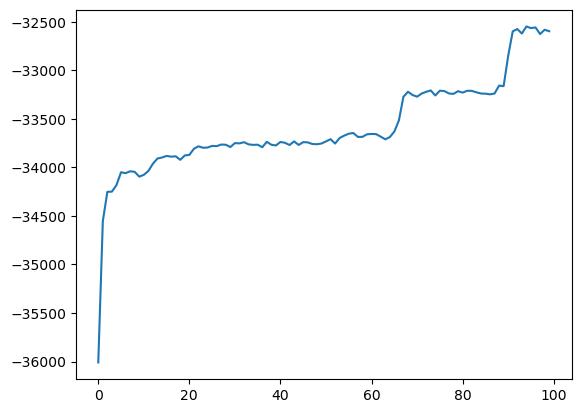

In [119]:
plt.plot(log_likelihoods)

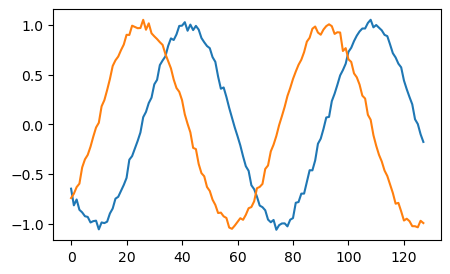

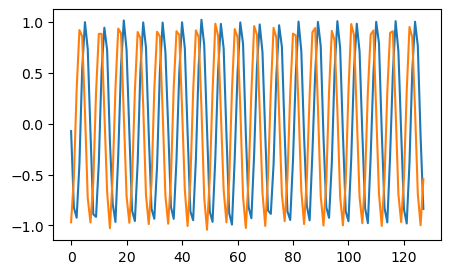

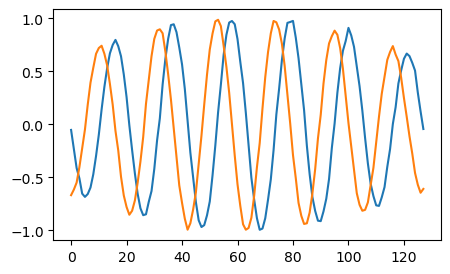

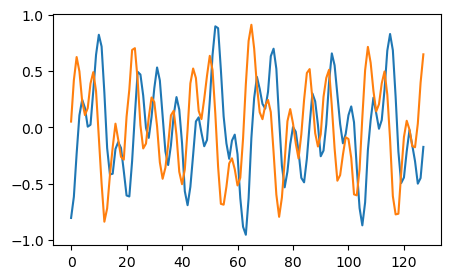

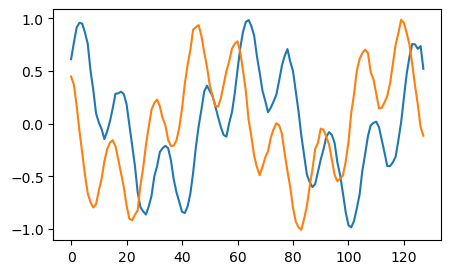

In [115]:
for i in range(K):
    plt.figure(i,figsize=(5,3))
    plt.plot(np.real(beta[i]))
    plt.plot(np.imag(beta[i]))

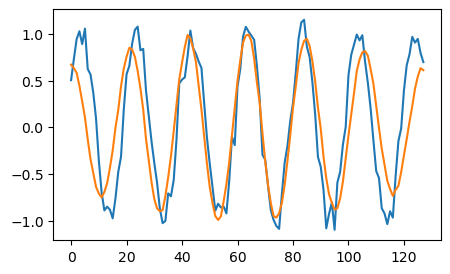

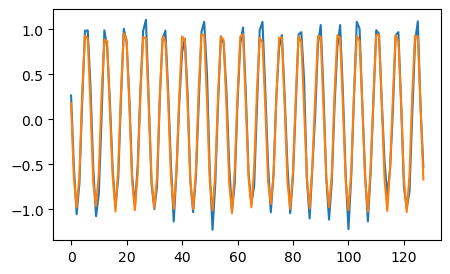

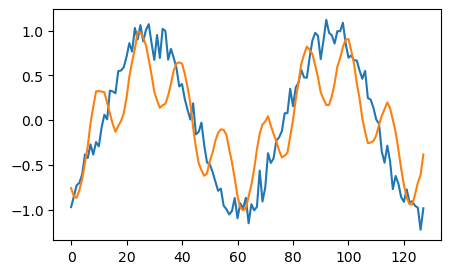

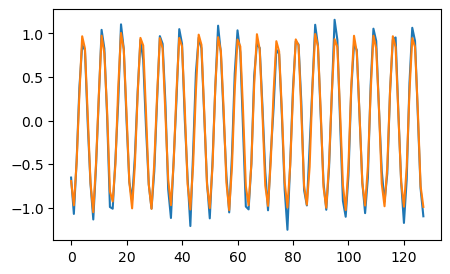

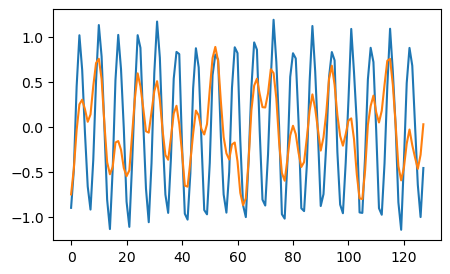

In [116]:
for i in range(5):
    plt.figure(i,figsize=(5,3))
    plt.plot(np.real(x[i]))
    plt.plot(np.real(beta[z[i]]*np.exp(2j*np.pi*phi[i])))
    